# 实验五：层次聚类
* 姓名：彭钰婷
* 学号：2013631
* 专业：计算机科学与技术

## 实验要求
### 基本要求
a) 实现single-linkage层次聚类算法； b) 实现complete-linkage层次聚类算法；
### 中级要求
a) 实现average-linkage层次聚类算法； b) 将上述三种算法的性能进行简要对比；
### 高级要求
通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析。

### 1. 生成数据集
数据包含2000个样例，每个样例的前3列表示特征，第4列表示标签。

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics.cluster import adjusted_rand_score
def create_data(centers,num=100,std=0.7):
    '''
    生成用于聚类的数据集
    :param centers: 聚类的中心点组成的数组。如果中心点是二维的，则产生的每个样本都是二维的。
    :param num: 样本数
    :param std: 每个簇中样本的标准差
    :return: 用于聚类的数据集。是一个元组，第一个元素为样本集，第二个元素为样本集的真实簇分类标记
    '''
    X, labels_true = make_blobs(n_samples=num, centers=centers, cluster_std=std)
    return  X,labels_true

centers=[[1,1,1],[1,3,3],[3,6,5],[2,6,8]]# 用于产生聚类的中心点, 聚类中心的维度代表产生样本的维度
X,labels_true= create_data(centers,2000,0.5) # 产生用于聚类的数据集，聚类中心点的个数代表类别数
np.savetxt('D:/Program Files/JupyterSpace/ML/lab5/data.dat',X)
np.savetxt('D:/Program Files/JupyterSpace/ML/lab5/label.dat',labels_true)
print("generate data finish!")

generate data finish!


### 2. 初级&中级要求：实现single-linkage、complete-linkage、average-linkage层次聚类算法

In [2]:
import numpy as np

MAX_NUM = 1e3

# method
def singleLinkage(X):
    # your code
    Minres = []
    for i in range(len(X[0])):
        Minres.append(MAX_NUM)
    for i in range(len(X[0])):
        if X[0][i] < Minres[i]:
            Minres[i] = X[0][i]
        if X[1][i] < Minres[i]:
            Minres[i] = X[1][i];
    return Minres
    
def completeLinkage(X):
    # your code
    Maxres = []
    for i in range(len(X[0])):
        Maxres.append(0)
    for i in range(len(X[0])):
        if X[0][i] > Maxres[i]:
            Maxres[i] = X[0][i]
        if X[1][i] > Maxres[i]:
            Maxres[i] = X[1][i];
    return Maxres

def averageLinkage(setList,dest,src,allDist):
    # your code
    Avgres = []
    for clu in range(len(setList)):
        if clu == dest or clu == src:
            Avgres.append(0)
            continue
        sumdistance = 0
        for other_cluster_element in setList[clu]:
            for dest_cluster_element in setList[dest]:
                sumdistance += allDist[dest_cluster_element][other_cluster_element]
            for src_cluster_element in setList[src]:
                sumdistance += allDist[src_cluster_element][other_cluster_element]
        res = sumdistance/((len(setList[dest])+len(setList[src]))*len(setList[clu]))
        Avgres.append(res)                    
    return Avgres
    
class AgglomerativeClustering:
    def __init__(self):
        # 对每次的合并进行记录
        self.steps=[]

    def fit(self,datas,method):
        self.dataCnt = datas.shape[0]# dataCnt为总数据条数
        # 预处理各点之间的距离
        allDist = np.zeros((self.dataCnt,self.dataCnt))# allDist为各点之间的距离
        for i in range(self.dataCnt):
            for j in range(i):
                allDist[i][j] = allDist[j][i] = np.sum((datas[i]-datas[j])**2)
        setList, clusterCount = [[i] for i in range(self.dataCnt)], self.dataCnt
        # setList为这一类有哪些数据，clusterCount为聚类个数(初始化为数据条数)
        print("calculate distance finish!")

        # 聚类间距离矩阵
        clusterDist = np.zeros((self.dataCnt,self.dataCnt))+MAX_NUM# clusterDist为聚类间距离矩阵
        for i in range(clusterCount):
            for j in range(i+1,clusterCount):
                clusterDist[i][j] = clusterDist[j][i] = allDist[i][j]
        print("calculate cluster distance finish!")

        while clusterCount != 1:# 反复聚类直到只剩下一类
            # 最相似的两个聚类
            res = np.argmin(clusterDist)# res为距离最短的两类(i类和j类)的下标(i,j)
            dest,src = int(res/clusterCount),res%clusterCount# dest为i类，src为j类
            # steps进行一次记录
            self.steps.append((setList[dest][0],setList[src][0]))# steps用于记录每次合并
            # 聚类间距离矩阵更新
            if(method == averageLinkage):
                modify = method(setList,dest,src,allDist)
            else:
                modify = method(clusterDist[[dest,src]])            
            clusterDist[dest] = modify# 所有其他类到新类的距离(一排)
            clusterDist[:,dest] = modify# 所有其他类到新类的距离(一列)
            clusterDist = np.delete(clusterDist,src,axis=0)
            clusterDist = np.delete(clusterDist,src,axis=1)
            clusterDist[dest][dest] = MAX_NUM
            # 聚类更新
            setList[dest] = setList[dest] + setList[src]
            del setList[src]
            clusterCount -= 1# 总类数-1
            if (self.dataCnt - clusterCount) % (self.dataCnt / 20) == 0:
                print(clusterCount, " clusters left.")# 打印还剩多少类
        print("cluster finish !")

    def label(self,k):
        root = list(range(self.dataCnt))
        def find_root(n):
            if root[root[n]] == root[n]:
                return root[n]
            root[n]=find_root(root[n])
            return root[n]
        for i in range(self.dataCnt-k): # 根据steps记录产生非连通图
            src,dest = self.steps[i]
            root[find_root(dest)] = find_root(src)
        cluster, clusterNum = [0 for i in range(self.dataCnt)], 0
        for i in range(self.dataCnt): # 将根节点标注为新的cluster
            if i == root[i]: # i是根
                clusterNum += 1
                cluster[i] = clusterNum
        for i in range(self.dataCnt): # 将非根节点标注为根节点的cluster
            if i != root[i]: # i不是根
                cluster[i] = cluster[find_root(i)]
        return cluster

In [3]:
from itertools import permutations
def accuracy_cal(labels_true,labels_predict,k):
    labels_reshuffle = [0 for i in range(len(labels_true))]
    combination = list(permutations([i for i in range(1,k+1)],k))
    acclis = []
    for i in range(len(combination)):# 每个组合都试一下，算出acc
        comindex = 0
        for j in range(1,k+1):#修改每类的label
            for index in range(len(labels_true)):# 把所有label为j的都改成combination[i][comindex]
                if labels_true[index] == j:
                    labels_reshuffle[index] = combination[i][comindex]
            comindex += 1
        # 计算acc
        acc = 0
        for j in range(len(labels_reshuffle)):
            if(labels_reshuffle[j] == labels_predict[j]):
                acc += 1
        acclis.append(acc/len(labels_reshuffle))
#     print("acclis is :{0}".format(acclis))
    return max(acclis)

calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
accuracy for <function singleLinkage at 0x000001D325121EE0> is:0.4991242803198932
-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clust

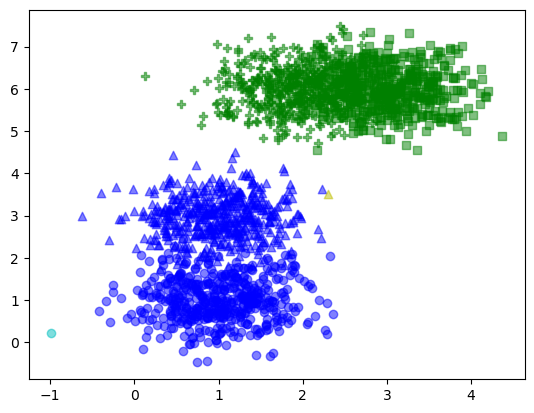

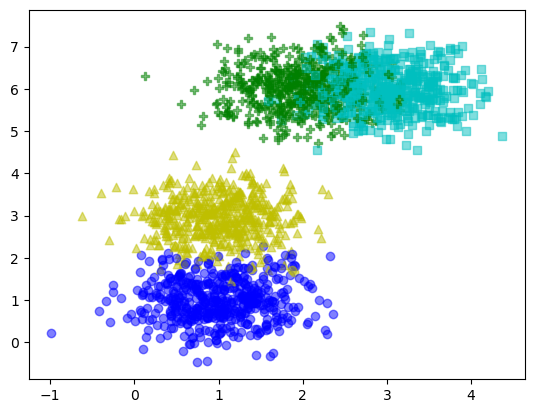

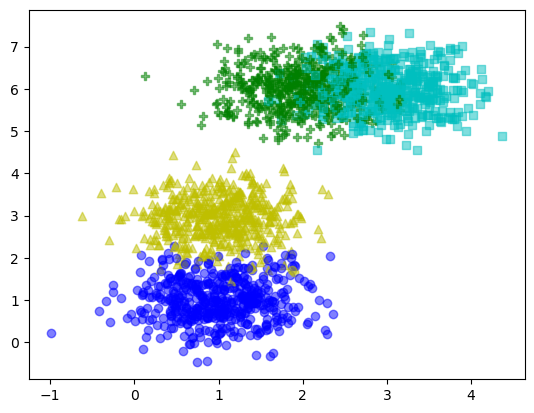

In [4]:
def plot_data(*data):
    '''
    绘制用于聚类的数据集
    :param data: 可变参数。它是一个元组。元组元素依次为：第一个元素为样本集，第二个元素为样本集的真实簇分类标记，第三个元素为预测分类标记
    :return: None
    '''
    X,labels_true,labels_predict,cnt=data
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    colors='rgbyckm' # 每个簇的样本标记不同的颜色
    markers='o^sP*DX'
    for i in range(len(labels_true)):
        predict=labels_predict[i]
        ax.scatter(X[i,0],X[i,1],label="cluster %d"%labels_true[i],
        color=colors[predict%len(colors)],marker=markers[labels_true[i]%len(markers)],alpha=0.5)
        
METHOD_APPLY = [singleLinkage,completeLinkage,averageLinkage]

cnt=0
for method in METHOD_APPLY:
    model = AgglomerativeClustering()
    model.fit(X,method)
    k=4
    labels_predict = model.label(k)
    acc = adjusted_rand_score(labels_predict, labels_true)
    print("accuracy for {0} is:{1}".format(str(method),acc))
    plot_data(X,labels_true,labels_predict,cnt)
    cnt+=1
    print("-------Segmentation-------")

### 3. 中级要求：性能比较
列出三种算法的accuracy表格如下：

| 方法 | accuracy |
|:--------:| :---------:|
| singleLinkage | 0.4991 |
| completeLinkage | 0.9907 |
| averageLinkage | 0.9762 |

可以看出，singleLinkage算法最差，从聚类图中也可看出它常常将大部分数据分为2类或3类，第3/4类只有极少量的点；completeLinkage和averageLinkage算法明显表现很好。
原因解释如下：
* singleLinkage容易造成两个聚类明明从整体上看相隔很远，但由于其中个别点的距离较近就被合并了，且合并后这种情况会恶化，类似链式效应，这也是为什么singleLinkage表现出容易合并两个明显不同但存在相交的类。
* 上述两种聚类方法的共同问题就是只考虑了某个极端的属性(如最近距离和最远距离)，而没有考虑类内数据的整体特点。averageLinkage把两个集合中的点两两距离全部放在一起求平均值，考虑了所有点对，更全面，**在改变方差进行实验时会发现averageLinkage相较completeLinkage更稳健**。

### 4. 高级要求

In [7]:
acclis = [[],[],[]]# 二维list，第二维表示不同方法，第一维表示不同clusternum
centerlis = [[1,1,1],[1,3,3],[3,6,5],[2,6,8],[2,5,6],[3,4,7],[4,7,8]]
for clunum in range(2,8):
    centers=[centerlis[i] for i in range(clunum)]# 用于产生聚类的中心点, 聚类中心的维度代表产生样本的维度
    X,labels_true= create_data(centers,2000,0.5) # 产生用于聚类的数据集，聚类中心点的个数代表类别数
    for methodindex in range(len(METHOD_APPLY)):
        model = AgglomerativeClustering()
        model.fit(X,METHOD_APPLY[methodindex])
        labels_predict = model.label(clunum)
        acclis[methodindex].append(adjusted_rand_score(labels_predict, labels_true))
#         acclis[methodindex].append(accuracy_cal(labels_true,labels_predict,clunum))
#         print("accuracy for {0} is:{1},with clunum={2}".format(str(METHOD_APPLY[methodindex]),acclis[methodindex][clunum-2],clunum))
    print("-------Segmentation-------")

calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
calculate distance finish!
calculate cluster distance finish!


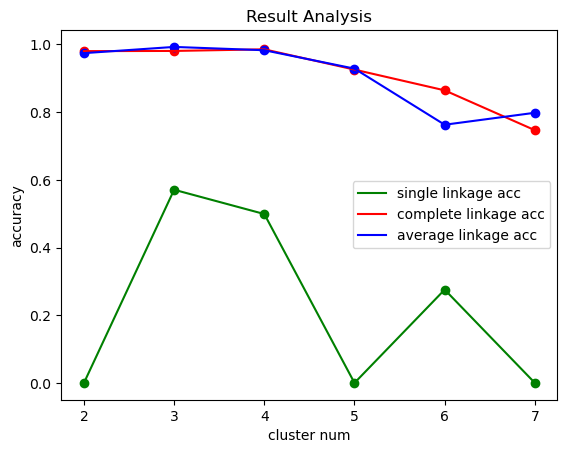

In [8]:
k = [i for i in range(2, 8)]
plt.title('Result Analysis')
plt.plot(k, acclis[0], color='green', label='single linkage acc')
plt.plot(k, acclis[1], color='red', label='complete linkage acc')
plt.plot(k, acclis[2], color='blue', label='average linkage acc')
plt.scatter(k, acclis[0],color='green')
plt.scatter(k, acclis[1], color='red')
plt.scatter(k, acclis[2], color='blue')
plt.legend()  # 显示图例

plt.xlabel('cluster num')
plt.ylabel('accuracy')
plt.show()

* acc：
从acc曲线可以看出，complete linkage和average linkage效果远优于single linkage。average linkage和complete linkage不相上下，但总体而言average linkage更加稳健。这是因为complete linkage虽然解决了single linkage中链式反应的问题，但对离群点的处理能力不足，而average linkage考虑了所有情况，更加全面，故效果最好。

* 时间复杂度：值得一提的是，运行复杂度方面average linkage高于另外两种算法，这是因为它每次计算都要考虑全部的组合情况，而single linkage和complete linkage只需找出两类中较小/大的那个distance即可。

因此，模型选择时需要在时间和空间上折中。